## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 

Ссылка на проект - https://github.com/runnerup96/Numpy-NN-Framework

Все необходимые доработки обозначены в проекте тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

**Ссылка на версию проекта со всеми необходимыми доработками:**  
https://github.com/DmitryInd/Numpy-NN-Framework

In [1]:
# Пример импорта модуля
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "src"))

from nn.module import sequential

# пример быстрой перезагрузки модуля без рестарта ноутбука
import importlib
importlib.reload(sequential)

<module 'nn.module.sequential' from '/home/dmitryindenbom/Documents/PyProjects/Numpy-NN-Framework/src/nn/module/sequential.py'>

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке **test_CIFAR_training.py**

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
* Процесс обучения нейронной сети с помощью training.train.train
* Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
* Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
* Расчет точности общей точности модели и расчет по классовой точности с помощью sklearn.metrics.classification_report
* Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат. 

### Перед началом экспериментов скачаем и предобработаем набор данных.  
(Следующие ячейки скопированы из test_CIFAR_training.ipynb).

In [2]:
import glob
import pickle
import numpy as np

Загрузим датасет

In [3]:
# import wget
# wget.download("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")

И распакуем его

In [4]:
# !tar -xzf cifar-10-python.tar.gz

На выходе будем иметь следующие файлы

In [5]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


Из этих файлов нас интересуют data_batch_1, data_batch_2, ..., data_batch_5 -- это файлы с тренировочными данными, и файл test_batch -- это файл с тестовыми данными, на которых мы будем измерять свои метрики.

Посмотрим ближе на структуру файлов

In [6]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

Датасет содержит следующие ключи:

In [7]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


Ключ `batch_label` нас не интересует, так как содержит только лишь информацию о номере бача

In [8]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

Ключ `filenames` в данном случае нас тоже не интересует, так как он содержит названия файлов, которые мы без привлечения языковых моделей использовать не сможем

In [9]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


Остаются два наиболее интересных ключа, это `data` и `labels`.

Как нетрудно догадаться, `labels` содержит классы. Выведем первые 10 элементов:

In [10]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


Классы представлены числовыми метками. В принципе нам нет необходимости знать соответствие между ними, однако эти данные можно найти в файле `batches.meta`:

In [11]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Ключ `data` содержит уже сами числовые данные

In [12]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


Теперь интересно посмотреть на сбалансированность меток по разбиениям. Для этого загрузим все тестовые разбиения

In [13]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

И посчитаем сколько раз каждая метка встречается в каждом датасете

In [14]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


Как видим, данные не сбалансированы по разбиениям, поэтому объединим все в один датасет и разобьем это на два датасета, тренировочный и валидационный, при этом сразу поделим значения каждого вектора на 256, чтобы иметь интенсивность в относительных единицах (хотя максимум на 255)

In [15]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

На валидационную выборку оставим 10000 элементов, по 1000 примеров из каждого класса, выбранных случайно

In [16]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

Подготовим еще тестовый датасет

In [17]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

Посмотрим на статистики

In [18]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


Дополнительно отнормируем все данные

In [19]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

In [20]:
from sklearn.metrics import classification_report

from dataset.dataloader import Dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.dropout import Dropout
from nn.layers.batch_norm import BatchNorm
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from nn.loss_functions.hinge_loss import hinge_loss
from training.train import train
from utils import gradient_check

import visualization_utils as viz_utils

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующее модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [21]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True),
	ReLU(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [22]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [23]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.4313  | 0.1138  |  2.3342  | 0.1124  | 0.111894 |   3.0    |   3.0    |
| 2/10|  2.2728  | 0.1254  |  2.2209  | 0.1214  | 0.050170 |   3.0    |   6.0    |
| 3/10|  2.1760  | 0.1335  |  2.1431  | 0.1303  | 0.033100 |   3.0    |   9.0    |
| 4/10|  2.1067  | 0.1405  |  2.0838  | 0.1364  | 0.022466 |   3.0    |   12.0   |
| 5/10|  2.0524  | 0.1464  |  2.0362  | 0.1448  | 0.017183 |   3.0    |   14.9   |
| 6/10|  2.0083  | 0.1529  |  1.9971  | 0.1517  | 0.014239 |   3.1    |   18.0   |
| 7/10|  1.9720  | 0.1573  |  1.9646  | 0.1569  | 0.011309 |   3.0    |   21.0   |
| 8/10|  1.9415  | 0.1623  |  1.9371  | 0.1600  | 0.009659 |   3.0    |   24.0   |
| 9/10|  1.9158  | 0.1671  |  1.9138  | 0.1619  | 0.007912 |   3.1    |   27.0   |
|10/10|  1.8936  | 0.1711  |  1.8937  | 0.1652  | 0.007032 |   3.0    |   30.0   |


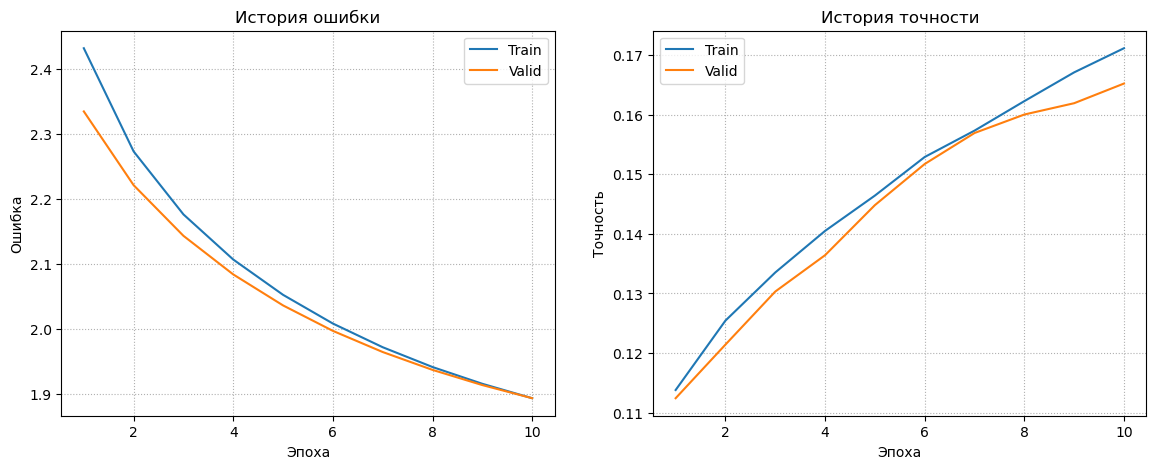

In [24]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [25]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8827
Точность на тесте: 0.1692


In [26]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.30      0.26      1000
           1       0.14      0.18      0.16      1000
           2       0.17      0.18      0.17      1000
           3       0.13      0.10      0.11      1000
           4       0.13      0.09      0.11      1000
           5       0.14      0.15      0.15      1000
           6       0.15      0.17      0.16      1000
           7       0.13      0.08      0.10      1000
           8       0.19      0.24      0.21      1000
           9       0.25      0.19      0.22      1000

    accuracy                           0.17     10000
   macro avg       0.17      0.17      0.17     10000
weighted avg       0.17      0.17      0.17     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Особенно высокие результаты (выше 16% точности) можно выделить у классов: 0 - airplane, 2 - bird, 8 - ship, 9 - truck. При этом на всех классах точность оказалась выше 12%, а значение общей точности достигло 17% - что означает, что модель работает лучше случайного выбора метки.  
  
В последующих экспериментах будем считать данную модель с ReLU функцией активации и обычным градиентным спуском **базовой** и сравнивать метрики качества всех новых архитектур с её показателями.

### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующее модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [27]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    Sigmoid(),
    Linear(20, 10),
    Sigmoid(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	Sigmoid(),
	Linear(20, 10, bias=True),
	Sigmoid(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [28]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [29]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.8640  | 0.1000  |  1.7656  | 0.0999  | 0.125610 |   3.1    |   3.1    |
| 2/10|  1.7074  | 0.1019  |  1.6153  | 0.1009  | 0.059801 |   3.1    |   6.3    |
| 3/10|  1.5691  | 0.1042  |  1.5063  | 0.1132  | 0.033313 |   3.2    |   9.5    |
| 4/10|  1.4818  | 0.1053  |  1.4482  | 0.1155  | 0.020476 |   3.1    |   12.6   |
| 5/10|  1.4329  | 0.1085  |  1.4100  | 0.1139  | 0.015194 |   3.2    |   15.8   |
| 6/10|  1.3980  | 0.1108  |  1.3796  | 0.1162  | 0.012750 |   3.2    |   19.0   |
| 7/10|  1.3693  | 0.1145  |  1.3539  | 0.1181  | 0.010899 |   3.2    |   22.1   |
| 8/10|  1.3448  | 0.1189  |  1.3318  | 0.1187  | 0.009696 |   3.1    |   25.3   |
| 9/10|  1.3237  | 0.1223  |  1.3127  | 0.1202  | 0.008418 |   3.1    |   28.3   |
|10/10|  1.3054  | 0.1253  |  1.2960  | 0.1232  | 0.007690 |   3.2    |   31.5   |


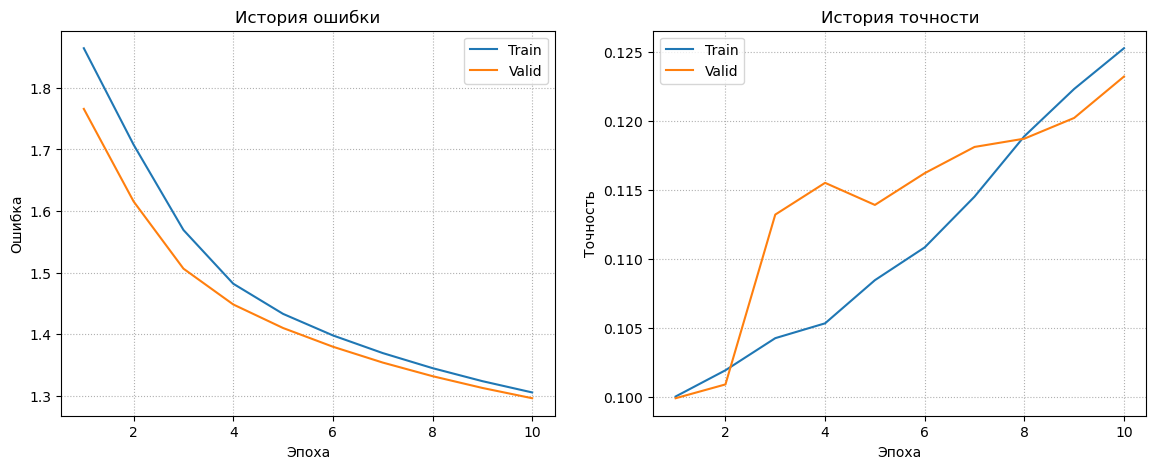

In [30]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [31]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.2954
Точность на тесте: 0.1223


In [32]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.13      0.23      0.17      1000
           1       0.16      0.18      0.17      1000
           2       0.12      0.21      0.15      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.13      0.20      0.16      1000
           6       0.10      0.18      0.13      1000
           7       0.00      0.00      0.00      1000
           8       0.11      0.20      0.14      1000
           9       0.10      0.02      0.03      1000

    accuracy                           0.12     10000
   macro avg       0.08      0.12      0.09     10000
weighted avg       0.08      0.12      0.09     10000



/home/dmitryindenbom/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmitryindenbom/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmitryindenbom/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение было произведено неравномерно. Предсказание некоторых классов было произведено с нулевой точностью: 3 - cat, 4 - deer, 7 - horse. Однако значение общей точности достигло 12% - что означает, что модель всё равно работает лучше случайного выбора метки.  
  
Сравнение с базовой моделью демонстрирует ухудшение качества нейронной сети при использовании сигмоиды в качестве функции активации. На это могло повлиять характерное для сигмоиды затухание градиентов при больших по модулю входных значениях, что привело бы к консервации части весов нейронной сети. При этом $L_2$ норма относительных градиентов (Grad/W) для сигмоиды совпадала с аналогичной у ReLU, что с учётом общего затухания градиентов (их уменьшения в 4 раза от каждого использования функции активации) в случае первой может указывать на остановке весов на слишком низких абсолютных значениях.

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [33]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    Tanh(),
    Linear(20, 10),
    Tanh(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 128),
    Tanh(),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	Tanh(),
	Linear(20, 10, bias=True),
	Tanh(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	Tanh(),
	Linear(768, 128, bias=True),
	Tanh(),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [34]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [35]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.0611  | 0.1243  |  2.0064  | 0.1264  | 0.122798 |   3.8    |   3.8    |
| 2/10|  1.9758  | 0.1359  |  1.9395  | 0.1396  | 0.044905 |   3.8    |   7.6    |
| 3/10|  1.9178  | 0.1449  |  1.8930  | 0.1497  | 0.040821 |   3.8    |   11.3   |
| 4/10|  1.8764  | 0.1529  |  1.8583  | 0.1573  | 0.033657 |   3.8    |   15.1   |
| 5/10|  1.8448  | 0.1583  |  1.8310  | 0.1622  | 0.029450 |   3.8    |   18.9   |
| 6/10|  1.8195  | 0.1633  |  1.8088  | 0.1670  | 0.025321 |   3.8    |   22.7   |
| 7/10|  1.7986  | 0.1675  |  1.7901  | 0.1722  | 0.022003 |   3.8    |   26.4   |
| 8/10|  1.7808  | 0.1721  |  1.7739  | 0.1763  | 0.018509 |   3.8    |   30.2   |
| 9/10|  1.7653  | 0.1766  |  1.7596  | 0.1801  | 0.016583 |   3.8    |   34.0   |
|10/10|  1.7517  | 0.1805  |  1.7469  | 0.1838  | 0.015826 |   3.8    |   37.8   |


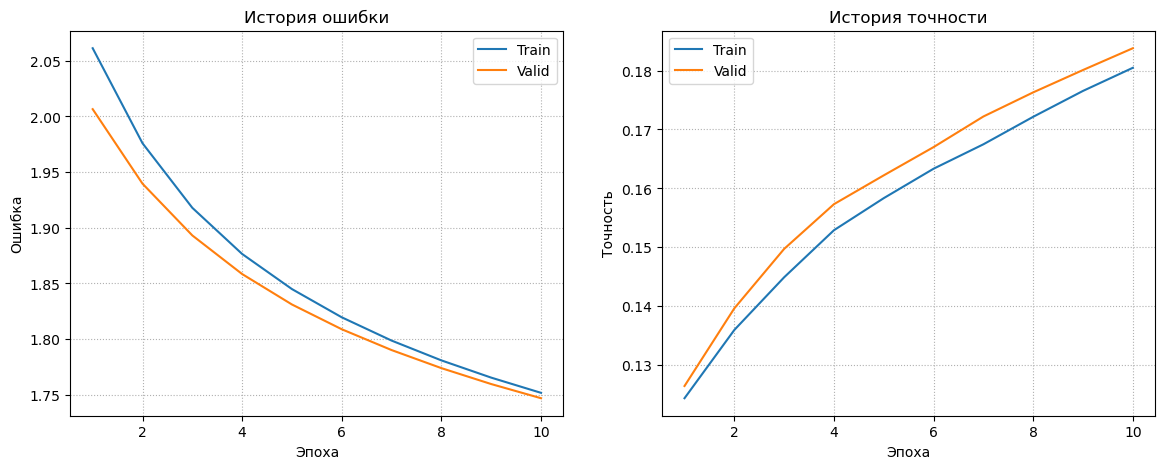

In [36]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [37]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.7523
Точность на тесте: 0.1791


In [38]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.29      0.25      1000
           1       0.21      0.17      0.19      1000
           2       0.13      0.13      0.13      1000
           3       0.13      0.11      0.12      1000
           4       0.14      0.14      0.14      1000
           5       0.16      0.17      0.16      1000
           6       0.18      0.17      0.18      1000
           7       0.16      0.13      0.14      1000
           8       0.23      0.26      0.24      1000
           9       0.23      0.21      0.22      1000

    accuracy                           0.18     10000
   macro avg       0.18      0.18      0.18     10000
weighted avg       0.18      0.18      0.18     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Особенно высокие результаты (выше 20% точности) можно выделить у классов: 0 - airplane, 1 - automobile, 8 - ship, 9 - truck. При этом на всех классах точность оказалась выше 12%, а значение общей точности достигло 18% - что означает, что модель работает лучше случайного выбора метки.  
  
Сравнение с базовой моделью демонстрирует небольшое улучшение качества нейронной сети при использовании гиперболического тангенса в качестве функции активации. С учётом более высокой нормы относительного градиента (Grad/W) у исследуемой архитектуры можно предположить, что улучшение связано с отсутвием зануления значений и градиентов функции активации для отрицательных входных признаков.

### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout. 

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [39]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    ReLU(),
    Dropout(p=0.1),
    Linear(20, 10),
    Dropout(p=0.1),
    ReLU(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Dropout(p=0.1),
    Linear(768, 128),
    ReLU(),
    Dropout(p=0.1),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(20, 10, bias=True),
	Dropout(p=0.1),
	ReLU(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(768, 128, bias=True),
	ReLU(),
	Dropout(p=0.1),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [40]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [41]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  2.6991  | 0.1125  |  2.3538  | 0.1108  | 0.114623 |   3.3    |   3.3    |
| 2/10|  2.5721  | 0.1224  |  2.2403  | 0.1209  | 0.052472 |   3.3    |   6.7    |
| 3/10|  2.4796  | 0.1318  |  2.1603  | 0.1301  | 0.033378 |   3.3    |   10.0   |
| 4/10|  2.4021  | 0.1394  |  2.0993  | 0.1370  | 0.024630 |   3.3    |   13.2   |
| 5/10|  2.3530  | 0.1462  |  2.0503  | 0.1425  | 0.019473 |   3.3    |   16.5   |
| 6/10|  2.3071  | 0.1516  |  2.0098  | 0.1489  | 0.014928 |   3.3    |   19.9   |
| 7/10|  2.2688  | 0.1575  |  1.9756  | 0.1563  | 0.012513 |   3.4    |   23.3   |
| 8/10|  2.2345  | 0.1628  |  1.9468  | 0.1604  | 0.011048 |   3.3    |   26.6   |
| 9/10|  2.2109  | 0.1678  |  1.9219  | 0.1661  | 0.008879 |   3.3    |   29.9   |
|10/10|  2.1792  | 0.1726  |  1.9005  | 0.1701  | 0.008698 |   3.3    |   33.3   |


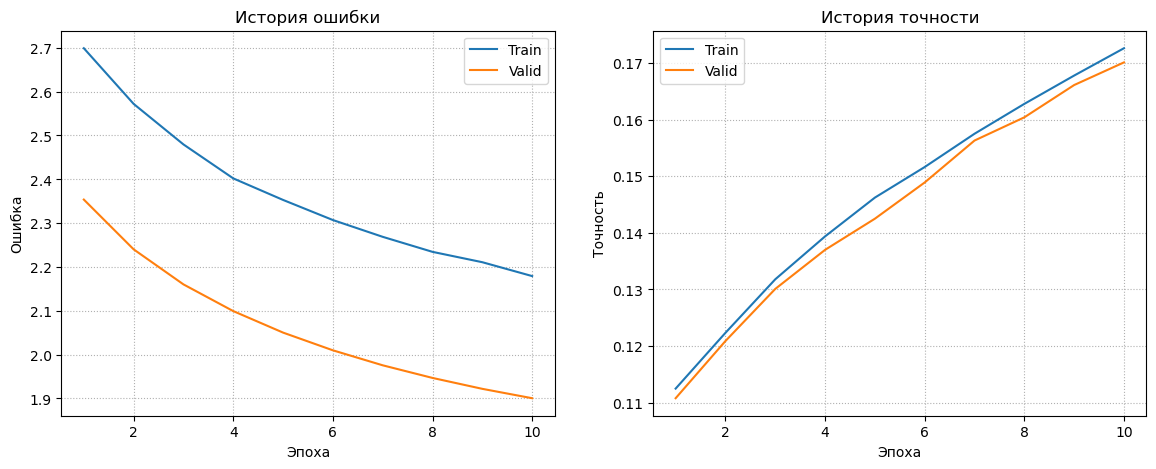

In [42]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [43]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.8884
Точность на тесте: 0.1715


In [44]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.22      0.30      0.25      1000
           1       0.15      0.21      0.17      1000
           2       0.17      0.14      0.16      1000
           3       0.14      0.10      0.12      1000
           4       0.14      0.11      0.12      1000
           5       0.15      0.14      0.15      1000
           6       0.16      0.17      0.16      1000
           7       0.14      0.08      0.10      1000
           8       0.18      0.27      0.22      1000
           9       0.26      0.18      0.21      1000

    accuracy                           0.17     10000
   macro avg       0.17      0.17      0.17     10000
weighted avg       0.17      0.17      0.17     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Особенно высокие результаты (выше 20% точности) можно выделить у классов: 0 - airplane, 9 - truck. При этом на всех классах точность оказалась выше 13%, а значение общей точности достигло 17% - что означает, что модель работает лучше случайного выбора метки.  

Сравнение с базовой моделью демонстрирует небольшое улучшение точности для отдельных классов и падение общей точности для всех меток при использовании Dropout слоя. Изменения точностей незначительны и могут являться погрешностью, более явный результат применения Dropout слоя должен быть заметен на большем количестве нейронов в 8-ом эксперименте.

### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### 1. Соберём две версии модели с помощью написанных инструментов: для проверки градиентов и обучения

In [45]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    ReLU(),
    BatchNorm(20),
    Linear(20, 10),
    ReLU(),
    BatchNorm(10),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	ReLU(),
	BatchNorm(in_dim=20, eps=1e-05),
	Linear(20, 10, bias=True),
	ReLU(),
	BatchNorm(in_dim=10, eps=1e-05),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	ReLU(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [46]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

In [47]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    optim_method="GD",
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.2423  | 0.1032  |  1.9151  | 0.1003  | 0.129305 |   3.8    |   3.8    |
| 2/10|  1.2398  | 0.1081  |  1.4783  | 0.1042  | 0.064206 |   3.8    |   7.6    |
| 3/10|  1.2374  | 0.1142  |  1.3494  | 0.1090  | 0.042892 |   3.8    |   11.5   |
| 4/10|  1.2350  | 0.1178  |  1.2949  | 0.1135  | 0.031578 |   3.9    |   15.3   |
| 5/10|  1.2327  | 0.1210  |  1.2675  | 0.1170  | 0.025101 |   3.8    |   19.1   |
| 6/10|  1.2305  | 0.1234  |  1.2520  | 0.1218  | 0.020500 |   3.8    |   23.0   |
| 7/10|  1.2283  | 0.1252  |  1.2425  | 0.1228  | 0.017719 |   3.8    |   26.8   |
| 8/10|  1.2262  | 0.1269  |  1.2361  | 0.1242  | 0.015397 |   3.8    |   30.6   |
| 9/10|  1.2241  | 0.1284  |  1.2315  | 0.1265  | 0.013302 |   3.9    |   34.5   |
|10/10|  1.2222  | 0.1299  |  1.2279  | 0.1283  | 0.011661 |   3.8    |   38.3   |


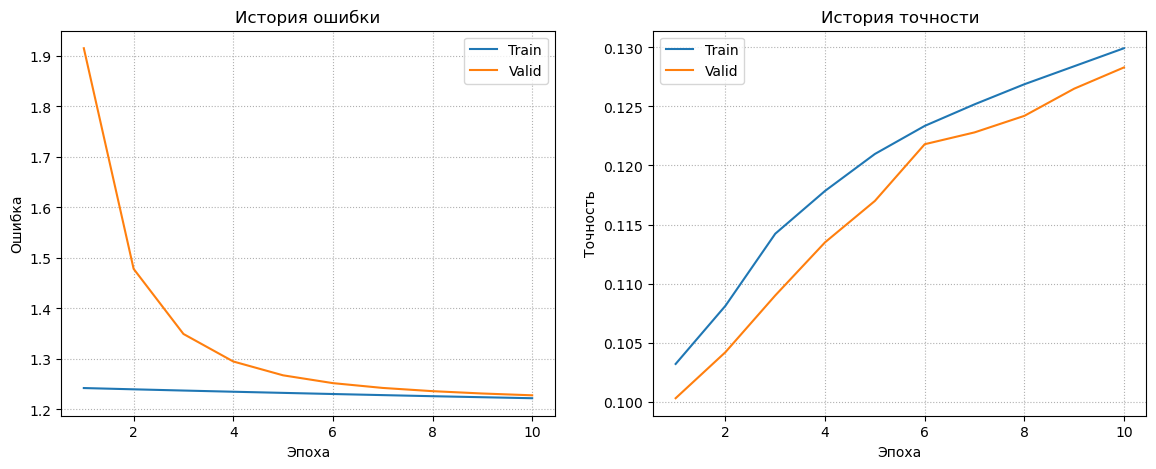

In [48]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

In [49]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.2217
Точность на тесте: 0.1301


In [50]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.08      0.06      0.07      1000
           1       0.13      0.11      0.12      1000
           2       0.13      0.18      0.15      1000
           3       0.15      0.15      0.15      1000
           4       0.18      0.23      0.20      1000
           5       0.11      0.12      0.11      1000
           6       0.10      0.10      0.10      1000
           7       0.08      0.04      0.06      1000
           8       0.17      0.21      0.18      1000
           9       0.12      0.09      0.10      1000

    accuracy                           0.13     10000
   macro avg       0.12      0.13      0.13     10000
weighted avg       0.12      0.13      0.13     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения. Расхождение значений Hinge Loss при обучении и тестировании объясняется изменением принципа работы Batch Normalisation при смене режима запуска.   
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Особенно высокие результаты (выше 14% точности) можно выделить у классов: 3 - cat, 4 - deer, 8 - ship. При этом на всех классах точность оказалась выше или равна 8%, а значение общей точности достигло 13% - что означает, что модель работает лучше случайного выбора метки.   
  
Сравнение с базовой моделью демонстрирует падение точности работы нейронной сети при использовании Batch Norm слоя. Ухудшение может быть связано с высокой $L_2$ нормой относительных градиентов (Grad/W), из-за которой обычный градиентный спуск не попадает в оптимальные значения весов.

### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### 1. Соберём три версии модели с помощью написанных инструментов: для проверки градиентов и обучения нейронной сети без и с BatchNorm

In [51]:
np.random.seed(42)
# Для проверки градиентов
exam_model = Sequential(
    Linear(3072, 20),
    ReLU(),
    Linear(20, 10),
    ReLU(),
    Linear(10, 10)
)
print("Для проверки градиентов:\n", exam_model)
# Для обучения
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)
print("Для обучения:\n", model)
# Для обучения с Batch Norm слоем
batch_norm_model = Sequential(
    Linear(3072, 768),
    ReLU(),
    BatchNorm(768),
    Linear(768, 128),
    ReLU(),
    BatchNorm(128),
    Linear(128, 10)
)
print("Для обучения с Batch Norm слоем:\n", model)

Для проверки градиентов:
 Sequential(
	Linear(3072, 20, bias=True),
	ReLU(),
	Linear(20, 10, bias=True),
	ReLU(),
	Linear(10, 10, bias=True)
)
Для обучения:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)
Для обучения с Batch Norm слоем:
 Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)


#### 2. Проверим градиенты модели:

In [52]:
test_x, test_y = Dataloader(train_data, batch_size=2).__next__()
print(f"Градиенты модели считаются{' не' if not gradient_check(test_x, test_y, exam_model) else ''} правильно")

Градиенты модели считаются правильно                                                    


#### 3. Обучим нейронную сеть и визуализируем изменяющиеся в процессе обучения метрики

##### Без Batch Normalisation

In [53]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  3.7860  | 0.2231  |  3.6470  | 0.2178  | 0.008114 |   3.1    |   3.1    |
| 2/10|  2.9488  | 0.2947  |  2.2291  | 0.2933  | 0.004873 |   3.0    |   6.1    |
| 3/10|  2.1964  | 0.3121  |  1.9525  | 0.3039  | 0.005623 |   3.1    |   9.2    |
| 4/10|  1.8061  | 0.3209  |  1.6644  | 0.3075  | 0.003018 |   3.0    |   12.2   |
| 5/10|  1.5246  | 0.3327  |  1.4614  | 0.3159  | 0.002976 |   3.0    |   15.2   |
| 6/10|  1.3835  | 0.3412  |  1.3165  | 0.3256  | 0.002929 |   3.0    |   18.2   |
| 7/10|  1.2492  | 0.3579  |  1.2468  | 0.3355  | 0.001815 |   3.0    |   21.2   |
| 8/10|  1.1933  | 0.3745  |  1.1957  | 0.3524  | 0.001476 |   3.0    |   24.3   |
| 9/10|  1.1439  | 0.3795  |  1.1526  | 0.3475  | 0.001493 |   3.1    |   27.3   |
|10/10|  1.0952  | 0.3745  |  1.1058  | 0.3473  | 0.001062 |   3.0    |   30.4   |


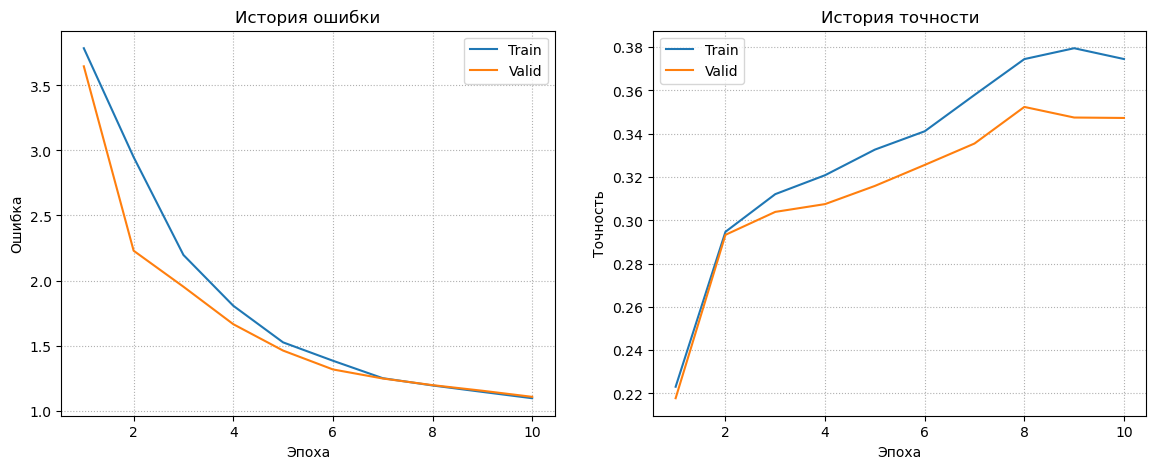

In [54]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

##### С Batch Normalisation

In [55]:
train_loss_history, valid_loss_history, \
train_acc_history, valid_acc_history = train(
    dataset=train_data,
    model=batch_norm_model,
    epochs=10,
    lr=0.001,
    valid_dataset=valid_data,
    batch_size=10000)

|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/10|  1.1718  | 0.2787  |  1.6515  | 0.2766  | 0.001332 |   3.9    |   3.9    |
| 2/10|  1.0534  | 0.3135  |  1.1910  | 0.3105  | 0.000637 |   3.9    |   7.8    |
| 3/10|  1.0262  | 0.3313  |  1.0850  | 0.3247  | 0.000686 |   3.9    |   11.8   |
| 4/10|  1.0138  | 0.3553  |  1.0520  | 0.3479  | 0.000430 |   3.9    |   15.6   |
| 5/10|  1.0066  | 0.3735  |  1.0302  | 0.3584  | 0.000393 |   3.9    |   19.6   |
| 6/10|  1.0005  | 0.4076  |  1.0129  | 0.3936  | 0.000412 |   3.9    |   23.5   |
| 7/10|  0.9951  | 0.4276  |  1.0036  | 0.4077  | 0.000386 |   3.9    |   27.4   |
| 8/10|  0.9900  | 0.4400  |  0.9983  | 0.4138  | 0.000546 |   3.9    |   31.3   |
| 9/10|  0.9844  | 0.4459  |  0.9935  | 0.4201  | 0.000353 |   4.0    |   35.3   |
|10/10|  0.9781  | 0.4547  |  0.9889  | 0.4223  | 0.000511 |   3.9    |   39.2   |


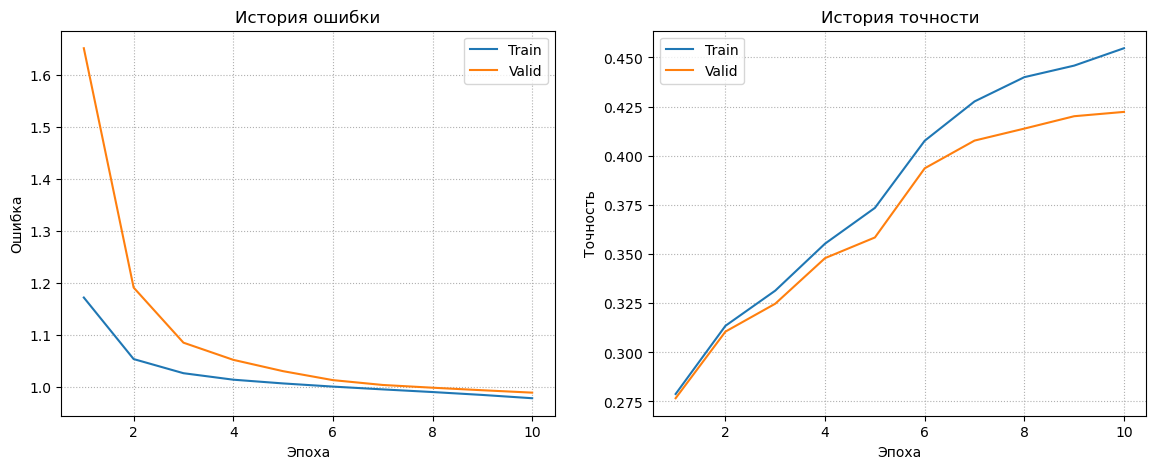

In [56]:
viz_utils.plot_learning_curves(train_loss_history, valid_loss_history,
                                train_acc_history, valid_acc_history)

#### 4. Расчёт общей и классовой точности модели на тестовых данных

##### Без Batch Normalization

In [57]:
test_dataloader = Dataloader(test_data, len(test_data), False)
model.eval()
vecs, labels = test_dataloader.__next__()
out = model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 1.1059
Точность на тесте: 0.3513


In [58]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.47      0.43      0.45      1000
           1       0.44      0.35      0.39      1000
           2       0.19      0.26      0.22      1000
           3       0.20      0.18      0.19      1000
           4       0.25      0.22      0.23      1000
           5       0.31      0.35      0.33      1000
           6       0.39      0.39      0.39      1000
           7       0.44      0.37      0.40      1000
           8       0.50      0.52      0.51      1000
           9       0.38      0.44      0.41      1000

    accuracy                           0.35     10000
   macro avg       0.36      0.35      0.35     10000
weighted avg       0.36      0.35      0.35     10000



##### C Batch Normalization

In [59]:
test_dataloader = Dataloader(test_data, len(test_data), False)
batch_norm_model.eval()
vecs, labels = test_dataloader.__next__()
out = batch_norm_model.forward(vecs)

loss = hinge_loss(out, labels)
test_loss = loss.item()

pred_labels = np.argmax(out.array, axis=-1)
test_acc = np.sum(pred_labels == labels) / len(labels)

print(f"Ошибка на тесте: {test_loss:.4f}")
print(f"Точность на тесте: {test_acc:.4f}")

Ошибка на тесте: 0.9871
Точность на тесте: 0.4339


In [60]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       0.53      0.50      0.52      1000
           1       0.61      0.49      0.55      1000
           2       0.37      0.19      0.25      1000
           3       0.30      0.15      0.20      1000
           4       0.31      0.46      0.37      1000
           5       0.40      0.34      0.37      1000
           6       0.42      0.50      0.46      1000
           7       0.41      0.57      0.48      1000
           8       0.52      0.64      0.57      1000
           9       0.45      0.51      0.48      1000

    accuracy                           0.43     10000
   macro avg       0.43      0.43      0.42     10000
weighted avg       0.43      0.43      0.42     10000



#### 5. Вывод:
Проверка градиентов показала совпадение численного и аналитического градиента в пределах погрешности, что подтверждает их правильно реализованный расчёт с помощью метода обратного распространения ошибки.  
  
Графики точности и ошибки в процессе обучения модели продемонстрировали стабильное улучшение её качества на протяжении всех эпох: уменьшение значений функции ошибки сопровождалось ростом общей точности нейронной сети, при этом точности на тренировочной и валидационной выборке изменялись симметрично. Следовательно, для задачи была написана подходящая функция ошибки, и нейронная сеть не перешла на стадию переобучения.  
  
Из анализа классовой точности на тестовом наборе данных можно заметить, что обучение на большей части меток произведено равномерно. Значение общей точности без использования Batch Normnalization достигло 35%, а использованием стандартизирующих слоёв $-$ 43%. Следовательно, обе модели работают лучше случайного выбора метки. При этом явно заметно преимущество модели с Batch Norm слоями, которые позволяют избежать вызванного функцией активации ReLU взрыва градиентов, что подтвержается $L_2$ нормой их относительных значений.  
  
Сравнение с базовой моделью из первого эксперимента демонстрирует значительное повышение качества работы нейронной сети при использовании оптимизатора AdamW для обучения, что и следовало ожидать.   
Для следующих экспериментов возьмём последнюю модель с Batch Normalization и алгоритмом оптимизации AdamW в качестве **базовой**.

### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качесвто? Выведите норму весов без регуляризации и с. 

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?